# Notebook to use for making figures for ICN 2024 poster

## Imports

In [31]:
import os 
import glob
import pickle

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from mosquito.process_abf import load_processed_data, detrend_emg
from mosquito.read_photron import my_read_cih, my_read_mraw
from mosquito.analyze_bursts import realign_spikes
from mosquito.util import set_plot_params

## Helper functions

In [32]:
def plot_emg_trace(data, time_range, ax=None, scalebar_size=1, ylim=None,
                   time_units='s', fig_params=None, line_color='k'):
    """
    Function to take in a data dictionary for a single fly and make
    a zoomed-out plot of the emg trace

    Args:
        - data: dictionary loaded from pickled *_processed.p file
        - time_window: tuple giving the range of data to plot 
            (e.g. (4, 8) will plot between t=4 and t=8 seconds)
        - ax: axis object to plot to
        - scalebar_size: size (duration) of scalebar, in seconds
        - figsize: tuple giving (width, height) of figure in inches 
            (passed to pyplot.subplots)
        - ylim: tuple giving y axis limits. If None, use auto scale
        - time_units: units of time values in data. should be 's'
        - fig_params: dictionary containing plot params; under 
            construction

    Returns:
        - fig, ax
    """
    # read out data from dict
    t = data['time']
    emg = data['emg']
    emg = detrend_emg(emg)

    # plot params
    # TODO: move this to params dictionary
    linewidth = 0.5 
    scalebar_linewidth = 2.0  # 1.5
    color = line_color
    
    # initialize figure (if needed)
    if ax is None:
        fig, ax = plt.subplots()

    # restrict time domain to time_range
    mask = (t >= time_range[0]) & (t <= time_range[-1])

    emg_curr = emg[mask]
    t_curr = t[mask]
    
    # plot. Note that we're subtracting off the initial time so it always
    # starts at t=0
    ax.plot(t_curr - time_range[0],
             emg_curr,
             color=color,
             lw=linewidth)

    # -----------------------------------------
    # axis properties
    # restrict x range
    ax.set_xlim([0, time_range[1] - time_range[0]])

    # restrict y range?
    if ylim is not None:
        ax.set_ylim(ylim)
        
    # add scalebar
    ax.spines['bottom'].set_bounds([0, scalebar_size])
    ax.spines['bottom'].set_linewidth(scalebar_linewidth)
    ax.spines['bottom'].set_position(('outward', 3))

    # label scalebar. 
    ax.set_xticks([scalebar_size/2])
    ax.set_xticklabels([f'{scalebar_size} {time_units}'])
    ax.tick_params(length=0)
    
    # remove other axis lines
    for spine in ['right', 'top', 'left']:
        ax.spines[spine].set_visible(False)

    # remove y ticks
    ax.set_yticks([])
    
    return ax


In [33]:
def make_trace_figure(data_folder, axo_num, time_range, scalebar_size=1, figsize=(2,4), save_flag=False, 
                      save_str='', save_ext='.svg', ylim=None, line_color='k'):
    """
    Wrapper to make emg trace figure
    """
    # load data
    data = load_processed_data(data_folder, axo_num)
    
    # make figure
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_emg_trace(data, time_range, ax=ax, scalebar_size=scalebar_size, ylim=ylim, line_color=line_color)
    
    # save?
    if save_flag:
        # make the filename of the figure reflect which data file it's from
        save_filename = f'{save_str}_{data_folder}_{axo_num:02d}{save_ext}'
    
        # save
        fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')

    return fig, ax
    

In [34]:
def plot_emg_waveform(data, ax=None, scalebar_size=0.01, figsize=(2,1), ylim=None, 
                      xlim=None, time_units='s', fig_params=None, line_color='k',
                     rm_flag=False):
    """
    Function to take in a data dictionary for a single fly and make
    a plot showing extracted spike/burst waveforms

    Args:
        - data: dictionary loaded from pickled *_processed.p file
        - ax: axis object to plot to
        - scalebar_size: size (duration) of scalebar, in seconds
        - figsize: tuple giving (width, height) of figure in inches 
            (passed to pyplot.subplots)
        - ylim: tuple giving y axis limits. If None, use auto scale
        - xlim: tuple giving x axis limits. If None, use auto scale
        - time_units: units of time values in data. should be 's'
        - fig_params: dictionary containing plot params; under 
            construction

    Returns:
        - ax
    """
    # plot params
    linewidth = 0.1 
    alpha = 0.2 
    scalebar_linewidth = 2.0
    color = line_color

    # read out signals from data dictionary
    window = round(data['params']['emg_window']/2)
    spikes = data['spikes']
    spike_idx = data['spike_idx']
    emg = data['emg']
    fs = data['sampling_freq']

    # realign spikes based on raw data (they are stored based on filtered alignment)
    spikes_realigned, _ = realign_spikes(data['spikes'], data['spike_idx'], 
                                         data['emg'], window=window, 
                                         thresh_factor=0.2)

    # remove some of early window
    cut_window = round(window/2)
    spikes_realigned = [spike[cut_window:] for spike in spikes_realigned]

    # remove some bad spikes?
    if rm_flag:
        spike_array = np.vstack(spikes_realigned)
        spike_array -= np.reshape(np.mean(spike_array[:, :window], axis=1), (-1, 1))  # zero the initial portion of spike waveform
        spike_mean = np.mean(spike_array, axis=0)
        spike_dist = np.sum((spike_array - spike_mean)**2, axis=1)
        spike_dist_z = (spike_dist - np.mean(spike_dist))/np.std(spike_dist)
        keep_ind = np.where(np.abs(spike_dist_z) < 5)[0]
        spikes_realigned_new = [spikes_realigned[ix] for ix in keep_ind]
        spikes_realigned = spikes_realigned_new
        
        
    # make figure
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    # define time range
    t_win = (1/fs)*(np.arange(spikes_realigned[0].shape[0]) - window)
    t_win -= t_win[0]
    
    # plot spikes
    for spike in spikes_realigned:
        ax.plot(t_win, spike - np.mean(spike[:round(window/2)]), '-', color=color,
                alpha=alpha, lw=linewidth)

    # ---------------------------------------
    # axis formatting

    # set x limits
    if xlim is None:
        xmin = t_win[0]
        xmax = t_win[-1]
        
    ax.set_xlim([xmin, xmax])

    if ylim is not None:
       ax.set_ylim(ylim)
        
    # add scalebar
    ax.spines['bottom'].set_bounds([xmin, xmin + scalebar_size])
    ax.spines['bottom'].set_linewidth(scalebar_linewidth)
    ax.spines['bottom'].set_position(('outward', 3))
    
    # label scalebar
    if (scalebar_size < 1) and (time_units == 's'):
        # switch  to milliseconds if we're using small values
        scalebar_label_val = round(1000*scalebar_size)
        scalebar_label = f'{scalebar_label_val} ms'
    else:
        scalebar_label = f'{scalebar_size} {time_units}'

    ax.set_xticks([scalebar_size/2])
    ax.set_xticklabels([scalebar_label])  # , fontsize='small')
    ax.tick_params(length=0)

    # remove y ticks
    ax.set_yticks([])
    
    # remove other axis lines
    for spine in ['right', 'top', 'left']:
        ax.spines[spine].set_visible(False)
    
    return ax 


In [35]:
def make_waveform_figure(data_folder, axo_num, scalebar_size=0.02, figsize=(2,4), save_flag=False, 
                          save_str='', save_ext='.svg', ylim=None, line_color='k', rm_flag=False):
    """
    Wrapper to make emg trace figure
    """
    # load data
    data = load_processed_data(data_folder, axo_num)
    
    # make figure
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_emg_waveform(data, ax=ax, scalebar_size=scalebar_size, ylim=ylim, line_color=line_color,
                          rm_flag=rm_flag)
    
    # save?
    if save_flag:
        # make the filename of the figure reflect which data file it's from
        save_filename = f'{save_str}_{data_folder}_{axo_num:02d}{save_ext}'
    
        # save
        fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')

    return fig, ax
    

In [36]:
def make_wbf_figure():
    """
    Make figure showing wingbeat frequency to accompany emg trace plots
    """

## Params

In [37]:
# PLOT PARAMETERS
plot_type = 'poster'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)

dark_flag = True
if dark_flag: 
    plt.style.use('dark_background')
else:
    plt.style.use('default')
    

In [38]:
# SAVE INFO
# where to save figures?
save_path = '/media/sam/SamData/Dropbox/Conferences/ICN 2024/poster/figs'
trace_save_str = 'trace'  # header for filenames of trace plots
waveform_save_str = 'waveform'  # header for filenames of wavefor plots

if dark_flag:
    trace_save_str += '_dark'
    waveform_save_str += '_dark'
    
# should we save plots?
save_trace_flag = True # if True, save the example emg trace plot; if False, don't
save_waveform_flag = True  # if True, save the example emg waveform plot; if False, don't

# how should figures be saved? (resolution, file format, etc)
save_dpi = 500 
save_ext_trace = '.svg'  # '.png'
save_ext_waveform = '.png'  # '.png'

In [39]:
# params for trace plots
trace_scalebar_size = 2 
trace_figsize = (1.16*8, 1.16*2)# (8, 2)

waveform_scalebar_size = 0.02 
waveform_figsize = (1.16*3, 1.16*2)

In [40]:
# EXAMPLE DATA INFO
# define identifying info for which data files we'll use here (can also do case by case basis)
mosquito_female_folder = 38
mosquito_female_axo = 10 
mosquito_female_ylim = (-0.28, 2.1)  # (-0.2569732666015625, 2.0193634033203125)

mosquito_male_folder = 37
mosquito_male_axo = 3 
mosquito_male_ylim = (-0.5, 3.05)  # (-0.4506072998046875, 2.9771575927734375)

drosophila_folder = 35
drosophila_axo = 0
drosophila_ylim = (-0.35, 4.75)  # (-0.33963775634765625, 4.621406555175781)


if dark_flag:
    mosquito_female_color = '#ffbb77'
    mosquito_male_color = '#44aa99'
    drosophila_color = '#aaaaaa'  # '#DDAA33'
else:
    mosquito_female_color = '#004488'
    mosquito_male_color = '#BB5566'
    drosophila_color = '#555555'  # '#DDAA33'

## Make example trace plots

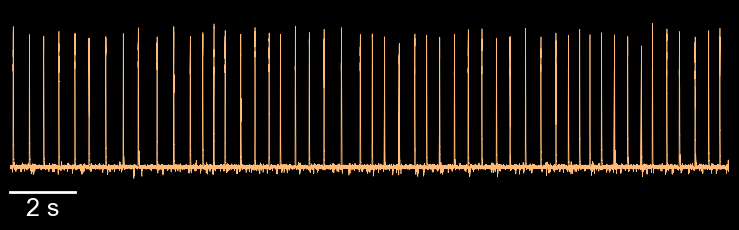

In [41]:
# example female mosquito
data_folder = mosquito_female_folder
axo_num = mosquito_female_axo 
time_range = (98, 120)

fig, ax = make_trace_figure(data_folder, axo_num, time_range, 
                            scalebar_size=trace_scalebar_size, 
                            figsize=trace_figsize, 
                            save_flag=save_trace_flag, 
                            save_str=trace_save_str, 
                            save_ext=save_ext_trace, 
                            ylim=mosquito_female_ylim,
                           line_color=mosquito_female_color)
                        


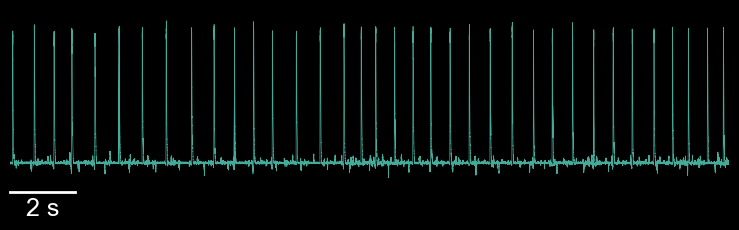

In [42]:
# example male mosquito
# load
data_folder = mosquito_male_folder
axo_num = mosquito_male_axo 
time_range = (1, 23)

fig, ax = make_trace_figure(data_folder, axo_num, time_range, 
                            scalebar_size=trace_scalebar_size, 
                            figsize=trace_figsize, 
                            save_flag=save_trace_flag, 
                            save_str=trace_save_str, 
                            save_ext=save_ext_trace,
                            ylim=mosquito_male_ylim,
                            line_color=mosquito_male_color)


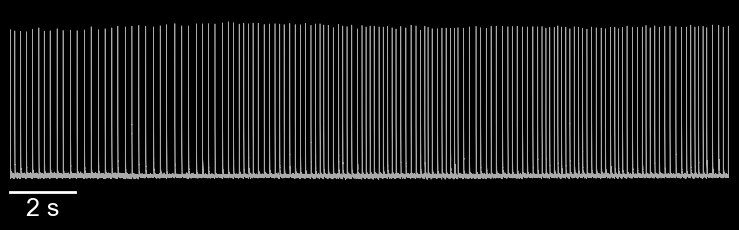

In [43]:
# example drosophila
# load
data_folder = drosophila_folder
axo_num = drosophila_axo 
time_range = (1, 23)

fig, ax = make_trace_figure(data_folder, axo_num, time_range, 
                            scalebar_size=trace_scalebar_size, 
                            figsize=trace_figsize, 
                            save_flag=save_trace_flag, 
                            save_str=trace_save_str, 
                            save_ext=save_ext_trace,
                            ylim=drosophila_ylim,
                            line_color=drosophila_color)


## Make example waveform plots

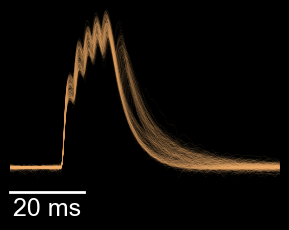

In [44]:
# example female mosquito
# load
data_folder = mosquito_female_folder
axo_num = mosquito_female_axo 

fig, ax = make_waveform_figure(data_folder, axo_num,
                                scalebar_size=waveform_scalebar_size, 
                                figsize=waveform_figsize, 
                                save_flag=save_waveform_flag, 
                                save_str=waveform_save_str, 
                                save_ext=save_ext_waveform,
                                ylim=mosquito_female_ylim,
                                line_color=mosquito_female_color)


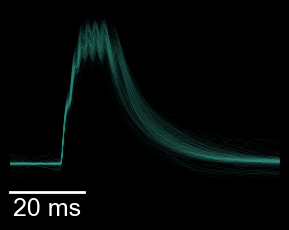

In [45]:
# example male mosquito
# load
data_folder = mosquito_male_folder
axo_num = mosquito_male_axo 


fig, ax = make_waveform_figure(data_folder, axo_num,
                                scalebar_size=waveform_scalebar_size, 
                                figsize=waveform_figsize, 
                                save_flag=save_waveform_flag, 
                                save_str=waveform_save_str, 
                                save_ext=save_ext_waveform,
                                ylim=mosquito_male_ylim,
                                line_color=mosquito_male_color,
                               rm_flag=True)

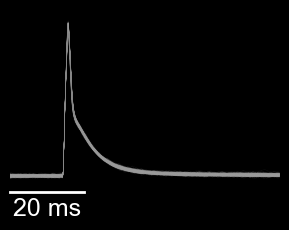

In [46]:
# example drosophila
# load
data_folder = drosophila_folder
axo_num = drosophila_axo 

fig, ax = make_waveform_figure(data_folder, axo_num,
                                scalebar_size=waveform_scalebar_size, 
                                figsize=waveform_figsize, 
                                save_flag=save_waveform_flag, 
                                save_str=waveform_save_str, 
                                save_ext=save_ext_waveform,
                                ylim=drosophila_ylim,
                                line_color=drosophila_color)